# Preprocess cholera outbreaks

This notebook cleans the weekly cholera outbreaks data from the [Integrated Disease Surveillance Programme of India](https://idsp.nic.in/) (IDSP) and saves it in shapefile format for further processing.

Prio to running this notebook, execute
- `download_cholera_outbreaks_data.py` to download the cholera outbreaks PDF files
- and `extract_tables_from_pdf_files.py` to extract the tables from the PDF files.

In [1]:
# import packages
import numpy as np
import pandas as pd
import re
import geopandas as gpd
import requests
import zipfile
import io

In [2]:
pd.set_option('display.max_rows', None)

## Load and inspect raw cholera outbreaks

In [3]:
cholera_outbreaks_raw = pd.read_csv('../../data/cholera_outbreaks_raw.csv')
cholera_outbreaks_raw.shape

(22836, 22)

In [4]:
cholera_outbreaks_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22836 entries, 0 to 22835
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  22836 non-null  object 
 1   0          19853 non-null  object 
 2   1          19481 non-null  object 
 3   2          19447 non-null  object 
 4   3          19413 non-null  object 
 5   4          19381 non-null  object 
 6   5          18382 non-null  object 
 7   6          16145 non-null  object 
 8   7          13655 non-null  object 
 9   8          11564 non-null  object 
 10  9          6535 non-null   object 
 11  10         730 non-null    object 
 12  11         383 non-null    object 
 13  12         216 non-null    object 
 14  13         138 non-null    object 
 15  14         84 non-null     object 
 16  15         29 non-null     object 
 17  16         12 non-null     object 
 18  17         4 non-null      object 
 19  18         3 non-null      object 
 20  19    

In [5]:
cholera_outbreaks_raw.head()

,file_name,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,31st_2010.pdf,Sr.,Name of State/UT,Name of District,Disease/ Illness,No. of cases/ deaths,Date of start of outbreak,Date of reporting,Current Status,Comments/ Action taken,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31st_2010.pdf,1.,Andhra Pradesh,Medak,i. Acute Diarrhoeal Disease,31 / 0,28.07.10,29.07.10,Under control,13 cases reported from village Chanaipet un...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31st_2010.pdf,1.,Andhra Pradesh,Prakasam,ii. Acute Diarhoeal Disease,30 / 1,26.07.10,29.07.10,Under surveillance,Outbreak occurred in Korrala village under...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31st_2010.pdf,1.,Andhra Pradesh,Warrangal,iii. Acute Diarrhoeal Disease,30 / 2,29.07.10,29.07.10,Under control,"Outbreak occurred in Thatikayala village, P...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31st_2010.pdf,2.,Chhattisgarh,Surguja,iv. Acute Diarrhoeal Disease,32 / 0,27.07.10,28.07.10,Under surveillance,Outbreak of diarrhoea reported from Villa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
cholera_outbreaks_raw.isna().sum()

file_name        0
0             2983
1             3355
2             3389
3             3423
4             3455
5             4454
6             6691
7             9181
8            11272
9            16301
10           22106
11           22453
12           22620
13           22698
14           22752
15           22807
16           22824
17           22832
18           22833
19           22833
20           22836
dtype: int64

## Filter rows containing cholera outbreaks

In [7]:
# drop duplicates
cholera_outbreaks_raw = cholera_outbreaks_raw.drop_duplicates().reset_index(drop=True)
cholera_outbreaks_raw.shape

(20287, 22)

In [8]:
# fill na
cholera_outbreaks_raw = cholera_outbreaks_raw.fillna('')

In [9]:
# make all columns lower case
cholera_outbreaks_raw = cholera_outbreaks_raw.apply(lambda x: x.astype(str).str.lower())

In [10]:
cholera_outbreaks_raw.head()

,file_name,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,31st_2010.pdf,sr.,name of state/ut,name of district,disease/ illness,no. of cases/ deaths,date of start of outbreak,date of reporting,current status,comments/ action taken,...,,,,,,,,,,
1,31st_2010.pdf,1.,andhra pradesh,medak,i. acute diarrhoeal disease,31 / 0,28.07.10,29.07.10,under control,13 cases reported from village chanaipet un...,...,,,,,,,,,,
2,31st_2010.pdf,1.,andhra pradesh,prakasam,ii. acute diarhoeal disease,30 / 1,26.07.10,29.07.10,under surveillance,outbreak occurred in korrala village under...,...,,,,,,,,,,
3,31st_2010.pdf,1.,andhra pradesh,warrangal,iii. acute diarrhoeal disease,30 / 2,29.07.10,29.07.10,under control,"outbreak occurred in thatikayala village, p...",...,,,,,,,,,,
4,31st_2010.pdf,2.,chhattisgarh,surguja,iv. acute diarrhoeal disease,32 / 0,27.07.10,28.07.10,under surveillance,outbreak of diarrhoea reported from villa...,...,,,,,,,,,,


In [11]:
# check cholera occurrences per column
for column in cholera_outbreaks_raw.columns:
    cholera_occurrences = cholera_outbreaks_raw[cholera_outbreaks_raw[column].str.contains('cholera')].shape[0]
    print(f'Number of cholera occurrences in column {column}: {cholera_occurrences}')

Number of cholera occurrences in column file_name: 0
Number of cholera occurrences in column 0: 132
Number of cholera occurrences in column 1: 341
Number of cholera occurrences in column 2: 31
Number of cholera occurrences in column 3: 568
Number of cholera occurrences in column 4: 87
Number of cholera occurrences in column 5: 293
Number of cholera occurrences in column 6: 124
Number of cholera occurrences in column 7: 132
Number of cholera occurrences in column 8: 281
Number of cholera occurrences in column 9: 485
Number of cholera occurrences in column 10: 0
Number of cholera occurrences in column 11: 0
Number of cholera occurrences in column 12: 1
Number of cholera occurrences in column 13: 0
Number of cholera occurrences in column 14: 2
Number of cholera occurrences in column 15: 1
Number of cholera occurrences in column 16: 0
Number of cholera occurrences in column 17: 0
Number of cholera occurrences in column 18: 0
Number of cholera occurrences in column 19: 0
Number of cholera o

In [12]:
# keep only rows that contain cholera
cholera_outbreaks_filtered = cholera_outbreaks_raw[cholera_outbreaks_raw.apply(lambda r: r.str.contains('cholera', case=False).any(), axis=1)].reset_index(drop=True)
cholera_outbreaks_filtered.shape

(1763, 22)

In [13]:
cholera_outbreaks_filtered.head()

,file_name,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,31st_2010.pdf,5.,himachal pradesh,shimla,cholera,235/ 1*,13.07.10,under control,outbreak reported from dinghu bawari of sanjau...,,...,,,,,,,,,,
1,31st_2010.pdf,8.,rajasthan,"alwar, sikar, jaipur",cholera,1095/0 #,20.07.10,under surveillance,outbreak occurred in 88 villages of koth...,,...,,,,,,,,,,
2,42nd_2010.pdf,2.,karnataka,tumkur,ii. acute diarrhoeal disease,13 / 0,08.10.10,08.10.10,under surveillance,"cases reported from kalluru village, kall...",...,,,,,,,,,,
3,42nd_2010.pdf,3.,karnataka,dharwad,viii. acute diarrhoeal disease,15 / 0,29.09.10,under control,"cases reported from hasarambi, hulkoppa p...",,...,,,,,,,,,,
4,39th_2010.pdf,1.,assam,dibrugarh,xvi. cholera,10 / 0,10.09.10,under surveillance,"cases reported from village boro line, khowang...",,...,,,,,,,,,,


In [14]:
cholera_outbreaks_filtered.tail()

,file_name,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
1758,8th_2018.pdf,kl/mlp/2018/08/0241,kerala,malappuram,cholera,22 00 13-01-18 13 00 12-02-16 14 00 22-01-18 0...,under surveillance,"cases reported from village nilambur, hsc r...",,,...,,,,,,,,,,
1759,31st_2018.pdf,tn/tnj/2018/31/1129,tamil nadu,thanjavur,acute diarrheal disease,17 00 02-08-18 03-08-18 15 00 31-07-18 31-07-1...,under control,cases of loose watery stools reported from v...,,,...,,,,,,,,,,
1760,31st_2018.pdf,dl/dln/2018/31/1135,delhi,north delhi,cholera,date of no. of no. of start cases deaths outbr...,under surveillance,cases of loose watery stools reported from vil...,,,...,,,,,,,,,,
1761,31st_2018.pdf,mh/nas/2018/27/961,maharashtra,nashik,cholera,date of no. of no. of start cases deaths outbr...,under surveillance,cases of watery stools with vomiting reporte...,,,...,,,,,,,,,,
1762,1st_2018.pdf,as/dbg/2018/01/0001,assam,dibrugarh,food poisoning,no. date of no. of date of of start of deaths ...,under control,"cases reported from village gerekoni gaon, ...",,,...,,,,,,,,,,


Briefly check each column supposedly containing cholera outbreaks and decide whether it can be dropped.

In [15]:
#cholera_outbreaks_filtered[cholera_outbreaks_filtered['3'].str.contains('cholera')]

## Extract and clean start dates

Now we need to extract and clean the start dates of outbreaks. We know that the start date of an outbreak is supposed to be mentioned right next to the number of cases and/or deaths.

In [20]:
# clean columns suspected to contain start dates
for col in outbreaks.columns[5:8]:
    outbreaks[col+'_clean'] = outbreaks[col].apply(lambda x: None if re.search('[a-zA-Z]', str(x)) is not None
                                                   else (None if len(str(x)) < 4
                                                         else x.replace('(', '').replace(')', '').replace('*', '')))

In [21]:
outbreaks.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10
3,growth,of,vibrio,cholera,01,on,culture,at,None,2010/39th_2010.pdf,cholera,1,None,None,None
4,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10


In [22]:
# extract the first date mentioned from the suspected columns
start_dates = []

for i, row in outbreaks.iterrows():
    dates = row[12:]
    start_date = next((i for i in dates if i is not None), None)
    start_dates.append(start_date)

In [23]:
outbreaks['start_date'] = start_dates

In [24]:
# check extracted start dates
outbreaks['start_date'].unique()

array(['13.07.10', '20.07.10', '10.09.10', None, '06.09.10', '24.09.10',
       '03.07.10', '24.06.10', '29.06.10', '27.06.10', '19.12.10',
       '29.07.10', '15.06.10', '04.11.10', '10.05.10', '21.09.10',
       '28.12.09', '11.12.10', '24.01.10', '17.08.10', '16.07.10',
       '27.05.10', '30.05.10', '22.10.10', '03.10.10', '20.08.10',
       '18.08.10', '28.02.10', '04.06.10', '24.10.10', '22.06.10',
       '29.11.10', '16.08.10', '06.08.10', '12.05.10', '03.05.10',
       '23.04.10', '12.07.10', '06.07.10', '06.06.11', '08.07.11',
       '27.06.11', '26.06.11', '03.03.11', '13.07.11', '15.10.11',
       '24.10.11', '23.09.11', '01.10.11', '08.03.11', '08.12.11',
       '11.12.11', '23.04.11', '18.04.11', '24.04.11', '07.04.11',
       '20.06.11', '14.06.11', '20.02.11', '11.07.11', '23.07.11',
       '20.04.11', '07.10.11', '03.01.11', '12.12.11', '14.10.11',
       '09.09.11', '22.08.11', '18.08.11', '20.08.11', '16.08.11',
       '21.08.11', '14.08.11', '20.03.11', '15.09.11', '

We see that the dates appear in many different formats. Thus, we should harmonise them.

In [25]:
# drop all rows that do not contain any date
outbreaks = outbreaks.loc[outbreaks['start_date'].notnull()].reset_index(drop=True)

In [26]:
# harmonise date formats to extract year
outbreaks['year'] = outbreaks['start_date'].apply(lambda x: x.split('.')[2] if '.' in x
                                                  else (x.split('/')[2] if '/' in x
                                                        else (x.split('-')[2] if '-' in x
                                                              else x)))

In [27]:
# further harmonise date formats and extract years
outbreaks['year'] = outbreaks['year'].str.pad(width=3, side='left', fillchar='0')
outbreaks['year'] = outbreaks['year'].str.pad(width=4, side='left', fillchar='2')
outbreaks['year'] = outbreaks['year'].astype(np.int64)

In [28]:
# check years
sorted(outbreaks['year'].unique())

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [29]:
# check case where there seems to be a typo
outbreaks.loc[(outbreaks['col9'] == '2015/39th_2015.pdf') & (outbreaks['year'] == 2019)]

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year
393,karnataka,bagalkot,vii.,cholera,66,00,20-09-19,25-09-19,None,2015/39th_2015.pdf,cholera,1,None,20-09-19,25-09-19,20-09-19,2019


In [30]:
# fix typo
outbreaks.loc[(outbreaks['col9'] == '2015/39th_2015.pdf') & (outbreaks['year'] == 2019), 'year'] = 2015

In [31]:
# harmonise date formats to extract month
outbreaks['month'] = outbreaks['start_date'].apply(lambda x: x.split('.')[1] if '.' in x
                                                   else (x.split('/')[1] if '/' in x
                                                         else (x.split('-')[1] if '-' in x
                                                               else x)))

In [32]:
# cast month to integer
outbreaks['month'] = outbreaks['month'].astype(np.int64)

In [33]:
# check months
sorted(outbreaks['month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [34]:
outbreaks.shape

(587, 18)

In [35]:
# drop all rows that do not contain data from 2010 to 2018
outbreaks = outbreaks.loc[outbreaks['year'].isin(years)].reset_index(drop=True)
outbreaks.shape

(586, 18)

In [36]:
outbreaks

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,pb/ldh/2018/44/1456,punjab,ludhiana,cholera,12,00,12-09-18,under,None,2018/44th_2018.pdf,cholera,1,None,12-09-18,None,12-09-18,2018,9
582,west,bengal,bardhaman,cholera,69,00,02-06-18,04-06-18,None,2018/23rd_2018.pdf,cholera,1,None,02-06-18,04-06-18,02-06-18,2018,6
583,basis.,ch/chd/2018/22/760,chandigarh,cholera,01,00,23-05-18,under,None,2018/23rd_2018.pdf,cholera,1,None,23-05-18,None,23-05-18,2018,5
584,kl/mlp/2018/08/0241,kerala,malappuram,cholera,03,00,01-02-18,under,None,2018/8th_2018.pdf,cholera,1,None,01-02-18,None,01-02-18,2018,2


## Map states, districts and location

Next, we need to map states and districts to their geographic location. We do this with the help of the [Database of Global Administrative Areas](https://www.gadm.org/index.html). We download the Level 2 administrative zones for India and explore them before we extract the relevant information and merge it with the outbreaks data.

In [37]:
!wget --recursive --no-directories --no-clobber --directory-prefix=../data/cholera_outbreaks https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IND_shp.zip

File ‘../data/cholera_outbreaks/gadm36_IND_shp.zip’ already there; not retrieving.



In [38]:
!unzip -u -d ../data/cholera_outbreaks/gadm36_IND_shp ../data/cholera_outbreaks/gadm36_IND_shp.zip

Archive:  ../data/cholera_outbreaks/gadm36_IND_shp.zip


In [39]:
path = '../data/cholera_outbreaks/gadm36_IND_shp'

In [40]:
file = 'gadm36_IND_2.shp'

In [41]:
india = gpd.read_file(os.path.join(path, file))

In [42]:
# check crs
india.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [43]:
india.shape

(666, 14)

In [44]:
india.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID_0      666 non-null    object  
 1   NAME_0     666 non-null    object  
 2   GID_1      666 non-null    object  
 3   NAME_1     666 non-null    object  
 4   NL_NAME_1  0 non-null      object  
 5   GID_2      666 non-null    object  
 6   NAME_2     666 non-null    object  
 7   VARNAME_2  190 non-null    object  
 8   NL_NAME_2  0 non-null      object  
 9   TYPE_2     666 non-null    object  
 10  ENGTYPE_2  666 non-null    object  
 11  CC_2       0 non-null      object  
 12  HASC_2     626 non-null    object  
 13  geometry   666 non-null    geometry
dtypes: geometry(1), object(13)
memory usage: 73.0+ KB


In [45]:
india.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.1_1,Nicobar Islands,None,None,District,District,None,IN.AN.NI,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.2_1,North and Middle Andaman,None,None,District,District,None,IN.AN.NM,"MULTIPOLYGON (((92.93898 12.22386, 92.93916 12..."
2,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.3_1,South Andaman,None,None,District,District,None,IN.AN.SA,"MULTIPOLYGON (((92.47972 10.52056, 92.47945 10..."
3,IND,India,IND.2_1,Andhra Pradesh,None,IND.2.1_1,Anantapur,"Anantpur, Ananthapur",None,District,District,None,IN.AD.AN,"POLYGON ((77.71420 13.76079, 77.71314 13.75074..."
4,IND,India,IND.2_1,Andhra Pradesh,None,IND.2.2_1,Chittoor,Chitoor|Chittor,None,District,District,None,IN.AD.CH,"POLYGON ((78.46293 12.63537, 78.46190 12.63228..."


<AxesSubplot:>

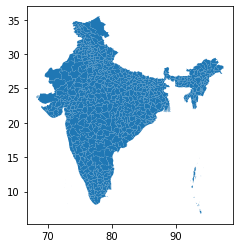

In [46]:
india.plot()

In [47]:
# select states, districts and geometry
states_districts = india[['NAME_1', 'NAME_2', 'geometry']].copy()

In [48]:
# rename columns
states_districts.columns = ['state', 'district', 'geometry']

In [49]:
# make states and districts lowercase to simplify the mapping
states_districts['state'] = states_districts['state'].str.lower()
states_districts['district'] = states_districts['district'].str.lower()

In [50]:
# create list with unique districts
districts = states_districts['district'].unique().tolist()

In [51]:
outbreaks.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9


In [52]:
# remove all but alphanumeric characters from columns suspected to contain states and districts
for col in outbreaks.columns[0:3]:
    outbreaks[col+'_clean'] = outbreaks[col].apply(lambda x: re.sub('\W', '', x))
    outbreaks[col+'_clean'] = outbreaks[col+'_clean'].apply(lambda x: None if len(x) < 3 else x)

In [53]:
outbreaks.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7,himachal,pradesh,shimla
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7,alwar,sikar,jaipur
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9,assam,dibrugarh,xvi
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9,karnataka,belgaum,xxi
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9,water,bharuch,xii


In [54]:
# harmonise district names in col1_clean to simplify mapping
outbreaks.loc[outbreaks['col1_clean'] == 'mahabubnagar', 'col1_clean'] = 'mahbubnagar'
outbreaks.loc[outbreaks['col1_clean'] == 'ahmedabad', 'col1_clean'] = 'ahmadabad'
outbreaks.loc[outbreaks['col1_clean'] == 'howrah', 'col1_clean'] = 'haora'
outbreaks.loc[outbreaks['col1_clean'] == 'hooghly', 'col1_clean'] = 'hugli'
outbreaks.loc[outbreaks['col1_clean'] == 'hoogly', 'col1_clean'] = 'hugli'
outbreaks.loc[outbreaks['col1_clean'] == 'villupuram', 'col1_clean'] = 'viluppuram'
outbreaks.loc[outbreaks['col1_clean'] == 'haridwar', 'col1_clean'] = 'hardwar'
outbreaks.loc[outbreaks['col1_clean'] == 'davangere', 'col1_clean'] = 'davanagere'
outbreaks.loc[outbreaks['col1_clean'] == 'davengere', 'col1_clean'] = 'davanagere'
outbreaks.loc[outbreaks['col1_clean'] == 'davangare', 'col1_clean'] = 'davanagere'
outbreaks.loc[outbreaks['col1_clean'] == 'tiruchirapalli', 'col1_clean'] = 'tiruchirappalli'
outbreaks.loc[outbreaks['col1_clean'] == 'darang', 'col1_clean'] = 'darrang'
outbreaks.loc[outbreaks['col1_clean'] == 'virudhunager', 'col1_clean'] = 'virudunagar'
outbreaks.loc[outbreaks['col1_clean'] == 'chikkaballapur', 'col1_clean'] = 'chikballapura'
outbreaks.loc[outbreaks['col1_clean'] == 'gondia', 'col1_clean'] = 'gondiya'
outbreaks.loc[outbreaks['col1_clean'] == 'purulia', 'col1_clean'] = 'puruliya'
outbreaks.loc[outbreaks['col1_clean'] == 'kalaburagi', 'col1_clean'] = 'gulbarga'
outbreaks.loc[outbreaks['col1_clean'] == 'kalburgi', 'col1_clean'] = 'gulbarga'
outbreaks.loc[outbreaks['col1_clean'] == 'gulburga', 'col1_clean'] = 'gulbarga'
outbreaks.loc[outbreaks['col1_clean'] == 'berhampur', 'col1_clean'] = 'ganjam'
outbreaks.loc[outbreaks['col1_clean'] == 'sholapur', 'col1_clean'] = 'solapur'
outbreaks.loc[outbreaks['col1_clean'] == 'raigad', 'col1_clean'] = 'raigarh'
outbreaks.loc[outbreaks['col1_clean'] == 'panchmahal', 'col1_clean'] = 'panch mahals'
outbreaks.loc[outbreaks['col1_clean'] == 'sibsagar', 'col1_clean'] = 'sivasagar'
outbreaks.loc[outbreaks['col1_clean'] == 'banaskantha', 'col1_clean'] = 'banas kantha'
outbreaks.loc[outbreaks['col1_clean'] == 'chamarajnagar', 'col1_clean'] = 'chamrajnagar'
outbreaks.loc[outbreaks['col1_clean'] == 'khargaon', 'col1_clean'] = 'west nimar'
outbreaks.loc[outbreaks['col1_clean'] == 'mysuru', 'col1_clean'] = 'mysore'
outbreaks.loc[outbreaks['col1_clean'] == 'mohali', 'col1_clean'] = 'sahibzada ajit singh nagar'
outbreaks.loc[outbreaks['col1_clean'] == 'delhi', 'col1_clean'] = 'west'
outbreaks.loc[outbreaks['col1_clean'] == 'kawardha', 'col1_clean'] = 'kabeerdham'
outbreaks.loc[outbreaks['col1_clean'] == 'chirtadurga', 'col1_clean'] = 'chitradurga'
outbreaks.loc[outbreaks['col1_clean'] == 'budgam', 'col1_clean'] = 'badgam'
outbreaks.loc[outbreaks['col1_clean'] == 'jangir', 'col1_clean'] = 'janjgir-champa'
outbreaks.loc[outbreaks['col1_clean'] == 'kancheepuramsaidapet', 'col1_clean'] = 'kancheepuram'

# harmonise district names in col2_clean to simplify mapping
outbreaks.loc[outbreaks['col2_clean'] == 'thiruvannamalai', 'col2_clean'] = 'tiruvannamalai'
outbreaks.loc[outbreaks['col2_clean'] == 'raigad', 'col2_clean'] = 'raigarh'
outbreaks.loc[outbreaks['col2_clean'] == 'davangere', 'col2_clean'] = 'davanagere'
outbreaks.loc[outbreaks['col2_clean'] == 'sibsagar', 'col2_clean'] = 'sivasagar'
outbreaks.loc[outbreaks['col2_clean'] == 'sabarkantha', 'col2_clean'] = 'sabar kantha'

In [55]:
outbreaks.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7,himachal,pradesh,shimla
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7,alwar,sikar,jaipur
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9,assam,dibrugarh,xvi
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9,karnataka,belgaum,xxi
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9,water,bharuch,xii


In [56]:
outbreaks.columns[18:]

Index(['col0_clean', 'col1_clean', 'col2_clean'], dtype='object')

In [57]:
# extract district strings from columns suspected to contain districts
for col in outbreaks.columns[18:]:
    outbreaks[col+'_district'] = outbreaks[col].apply(lambda x: None if x is None else next((d for d in districts if x in str(d)), None))

In [58]:
outbreaks.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7,himachal,pradesh,shimla,None,None,shimla
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7,alwar,sikar,jaipur,alwar,sikar,jaipur
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9,assam,dibrugarh,xvi,None,dibrugarh,None
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9,karnataka,belgaum,xxi,None,belgaum,None
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9,water,bharuch,xii,None,bharuch,None


In [59]:
# select processed columns suspected to contain districts
district_cols = [col for col in outbreaks.columns if 'district' in col]

In [60]:
# extract districts from processed columns suspected to contain districts
outbreaks_districts = []

for i, row in outbreaks.iterrows():
    all_district_cols = row[district_cols]
    district = next((i for i in all_district_cols if i is not None), None)
    outbreaks_districts.append(district)

In [61]:
# create new column with extracted districts
outbreaks['district'] = outbreaks_districts

In [62]:
# manually map missing districts
outbreaks.loc[(outbreaks['col4'] == '110') & (outbreaks['col6'] == '25/10/13'), 'district'] = 'bankura'
outbreaks.loc[(outbreaks['col4'] == '50') & (outbreaks['col6'] == '25/10/13') & (outbreaks['col7'] == '28/10/13'), 'district'] = 'bankura'
outbreaks.loc[(outbreaks['col4'] == '23') & (outbreaks['col6'] == '23/10/13') & (outbreaks['col7'] == '23/10/13'), 'district'] = 'puruliya'
outbreaks.loc[(outbreaks['col4'] == '13') & (outbreaks['col6'] == '31/07/13') & (outbreaks['col7'] == '31/07/13'), 'district'] = 'puruliya'
outbreaks.loc[(outbreaks['col4'] == '33') & (outbreaks['col6'] == '01/06/13') & (outbreaks['col7'] == '08/06/13'), 'district'] = 'chitradurga'
outbreaks.loc[(outbreaks['col4'] == '88') & (outbreaks['col6'] == '05/05/13'), 'district'] = 'sangli'
outbreaks.loc[(outbreaks['col4'] == '60') & (outbreaks['col6'] == '01/05/13') & (outbreaks['col7'] == '02/05/13'), 'district'] = 'puruliya'
outbreaks.loc[(outbreaks['col4'] == '36') & (outbreaks['col6'] == '19/04/13'), 'district'] = 'davanagere'
outbreaks.loc[(outbreaks['col4'] == '161') & (outbreaks['col6'] == '27/08/12'), 'district'] = 'nagpur'
outbreaks.loc[(outbreaks['col4'] == '73') & (outbreaks['col6'] == '22/07/12') & (outbreaks['col7'] == '23/07/12'), 'district'] = 'bankura'
outbreaks.loc[(outbreaks['col4'] == '19') & (outbreaks['col6'] == '21/07/12') & (outbreaks['col7'] == '21/07/12'), 'district'] = 'chikmagalur'
outbreaks.loc[(outbreaks['col4'] == '21') & (outbreaks['col6'] == '06/07/12') & (outbreaks['col7'] == '12/07/12'), 'district'] = 'birbhum'
outbreaks.loc[(outbreaks['col4'] == '59') & (outbreaks['col6'] == '25/05/12') & (outbreaks['col7'] == '25/05/12'), 'district'] = 'tumkur'
outbreaks.loc[(outbreaks['col4'] == '8') & (outbreaks['col6'] == '03/05/12') & (outbreaks['col7'] == '07/05/12'), 'district'] = 'wayanad'
outbreaks.loc[(outbreaks['col4'] == '26') & (outbreaks['col7'] == '16.08.11'), 'district'] = 'birbhum'
outbreaks.loc[(outbreaks['col4'] == '86') & (outbreaks['col6'] == '25/10/13') & (outbreaks['col7'] == '28/10/13'), 'district'] = 'bankura'
outbreaks.loc[(outbreaks['col4'] == '25') & (outbreaks['col6'] == '19/05/12'), 'district'] = 'mandya'
outbreaks.loc[(outbreaks['col4'] == '12') & (outbreaks['col6'] == '13.03.12') & (outbreaks['col7'] == '14.03.12'), 'district'] = 'mysore'

In [63]:
outbreaks

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
0,himachal,pradesh,shimla,cholera,235/,1*,13.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,13.07.10,None,13.07.10,2010,7,himachal,pradesh,shimla,None,None,shimla,shimla
1,"alwar,","sikar,",jaipur,cholera,1095/0,#,20.07.10,under,None,2010/31st_2010.pdf,cholera,1,None,20.07.10,None,20.07.10,2010,7,alwar,sikar,jaipur,alwar,sikar,jaipur,alwar
2,assam,dibrugarh,xvi.,cholera,10,/,0,10.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,10.09.10,10.09.10,2010,9,assam,dibrugarh,xvi,None,dibrugarh,None,dibrugarh
3,karnataka,belgaum,xxi.,cholera,19,/,0,06.09.10,None,2010/39th_2010.pdf,cholera,1,None,None,06.09.10,06.09.10,2010,9,karnataka,belgaum,xxi,None,belgaum,None,belgaum
4,water.,bharuch,xii.,cholera,2,/,0,24.09.10,None,2010/41st_2010.pdf,cholera,1,None,None,24.09.10,24.09.10,2010,9,water,bharuch,xii,None,bharuch,None,bharuch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,pb/ldh/2018/44/1456,punjab,ludhiana,cholera,12,00,12-09-18,under,None,2018/44th_2018.pdf,cholera,1,None,12-09-18,None,12-09-18,2018,9,pbldh2018441456,punjab,ludhiana,None,None,ludhiana,ludhiana
582,west,bengal,bardhaman,cholera,69,00,02-06-18,04-06-18,None,2018/23rd_2018.pdf,cholera,1,None,02-06-18,04-06-18,02-06-18,2018,6,west,bengal,bardhaman,west godavari,None,None,west godavari
583,basis.,ch/chd/2018/22/760,chandigarh,cholera,01,00,23-05-18,under,None,2018/23rd_2018.pdf,cholera,1,None,23-05-18,None,23-05-18,2018,5,basis,chchd201822760,chandigarh,None,None,chandigarh,chandigarh
584,kl/mlp/2018/08/0241,kerala,malappuram,cholera,03,00,01-02-18,under,None,2018/8th_2018.pdf,cholera,1,None,01-02-18,None,01-02-18,2018,2,klmlp2018080241,kerala,malappuram,None,None,malappuram,malappuram


In [64]:
outbreaks.shape

(586, 25)

In [65]:
# keep only rows that have a district
outbreaks = outbreaks.loc[outbreaks['district'].notnull()]
outbreaks.shape

(564, 25)

In [66]:
# map states and geometry to districts
outbreaks_mapped = pd.merge(states_districts, outbreaks, how='right', on='district')[['state', 'district', 'year', 'month', 'outbreak', 'geometry']].reset_index(drop=True)
outbreaks_mapped.shape

(573, 6)

In [67]:
outbreaks_mapped

,state,district,year,month,outbreak,geometry
0,himachal pradesh,shimla,2010,7,1,"POLYGON ((77.51051 30.78743, 77.50089 30.79253..."
1,rajasthan,alwar,2010,7,1,"POLYGON ((76.45745 27.08288, 76.44963 27.08627..."
2,assam,dibrugarh,2010,9,1,"POLYGON ((95.37698 27.10218, 95.37267 27.10167..."
3,karnataka,belgaum,2010,9,1,"POLYGON ((74.75089 15.49199, 74.74472 15.48939..."
4,gujarat,bharuch,2010,9,1,"MULTIPOLYGON (((72.67597 21.44681, 72.67597 21..."
...,...,...,...,...,...,...
568,punjab,ludhiana,2018,9,1,"POLYGON ((76.07124 30.56471, 76.06435 30.56714..."
569,andhra pradesh,west godavari,2018,6,1,"POLYGON ((81.81902 16.66214, 81.83632 16.64615..."
570,chandigarh,chandigarh,2018,5,1,"POLYGON ((76.80293 30.67548, 76.79437 30.66932..."
571,kerala,malappuram,2018,2,1,"POLYGON ((76.06149 10.72085, 76.05975 10.71879..."


In [68]:
# find districts with identical names appearing in different states
duplicate_districts = states_districts['district'].value_counts()[states_districts['district'].value_counts() > 1].index.tolist()
outbreaks_mapped[outbreaks_mapped['district'].isin(duplicate_districts)].sort_values('district')

,state,district,year,month,outbreak,geometry
517,maharashtra,aurangabad,2017,11,1,"POLYGON ((75.21554 19.55770, 75.20956 19.56258..."
446,maharashtra,aurangabad,2016,7,1,"POLYGON ((75.21554 19.55770, 75.20956 19.56258..."
516,bihar,aurangabad,2017,11,1,"POLYGON ((84.73145 25.05792, 84.73087 25.05387..."
445,bihar,aurangabad,2016,7,1,"POLYGON ((84.73145 25.05792, 84.73087 25.05387..."
163,chhattisgarh,bijapur,2012,8,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."
164,karnataka,bijapur,2012,8,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."
199,chhattisgarh,bijapur,2012,7,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."
200,karnataka,bijapur,2012,7,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."
443,chhattisgarh,bijapur,2016,3,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."
444,karnataka,bijapur,2016,3,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."


We need to check to which state the duplicated districts actually belong.

In [69]:
outbreaks.loc[(outbreaks['district'] == 'aurangabad') & (outbreaks['month'] == 11)] # maharashtra

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
530,mh/agb/2017/46/1591,maharashtra,aurangabad,cholera,5825,00,10-11-17,13-11-17,None,2017/46th_2017.pdf,cholera,1,None,10-11-17,13-11-17,10-11-17,2017,11,mhagb2017461591,maharashtra,aurangabad,None,None,aurangabad,aurangabad


In [70]:
outbreaks.loc[(outbreaks['district'] == 'aurangabad') & (outbreaks['month'] == 7)] # maharashtra

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
448,mh/agb/2016/27/1592,maharashtra,aurangabad,cholera,09,01,08-07-16,09-07-16,None,2016/27th_2016.pdf,cholera,1,None,08-07-16,09-07-16,08-07-16,2016,7,mhagb2016271592,maharashtra,aurangabad,None,None,aurangabad,aurangabad


In [71]:
outbreaks.loc[(outbreaks['district'] == 'bijapur') & (outbreaks['month'] == 8)] # karnataka

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
162,given.,bijapur,xvi,cholera,85,0,20/08/12,20/08/12,None,2012/34th_2012.pdf,cholera,1,None,20/08/12,20/08/12,20/08/12,2012,8,given,bijapur,xvi,None,bijapur,None,bijapur


In [72]:
outbreaks.loc[(outbreaks['district'] == 'bijapur') & (outbreaks['month'] == 7)] # karnataka

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
197,imparted.,bijapur,xi,cholera,32,0,08/07/12,12/07/12,None,2012/28th_2012.pdf,cholera,1,None,08/07/12,12/07/12,08/07/12,2012,7,imparted,bijapur,None,None,bijapur,None,bijapur


In [73]:
outbreaks.loc[(outbreaks['district'] == 'bijapur') & (outbreaks['month'] == 8)] # karnataka

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
162,given.,bijapur,xvi,cholera,85,0,20/08/12,20/08/12,None,2012/34th_2012.pdf,cholera,1,None,20/08/12,20/08/12,20/08/12,2012,8,given,bijapur,xvi,None,bijapur,None,bijapur


In [74]:
outbreaks.loc[(outbreaks['district'] == 'pratapgarh') & (outbreaks['month'] == 7)] # rajasthan

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
487,rj/pgr/2016/30/1789,rajasthan,pratapgarh,cholera,49,00,29-07-16,29-07-16,None,2016/30th_2016.pdf,cholera,1,None,29-07-16,29-07-16,29-07-16,2016,7,rjpgr2016301789,rajasthan,pratapgarh,None,None,pratapgarh,pratapgarh


In [75]:
outbreaks.loc[(outbreaks['district'] == 'raigarh') & (outbreaks['month'] == 7)] # maharashtra

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
72,maharashtra,raigad,xxii,cholera,67,/,0,11.07.11,None,2011/29th_2011.pdf,cholera,1,None,None,11.07.11,11.07.11,2011,7,maharashtra,raigarh,xxii,None,raigarh,None,raigarh
98,week.,11,raigad,cholera,94,/,0,11.07.11,None,2011/30th_2011.pdf,cholera,1,None,None,11.07.11,11.07.11,2011,7,week,None,raigarh,None,None,raigarh,raigarh


In [76]:
outbreaks.loc[(outbreaks['district'] == 'raigarh') & (outbreaks['month'] == 3)] # maharashtra

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col3_clean,outbreak,col5_clean,col6_clean,col7_clean,start_date,year,month,col0_clean,col1_clean,col2_clean,col0_clean_district,col1_clean_district,col2_clean_district,district
386,maharashtra,raigad,xxxi.,cholera,22,00,30/03/15,under,None,2015/16th_2015.pdf,cholera,1,None,30/03/15,None,30/03/15,2015,3,maharashtra,raigarh,xxxi,None,raigarh,None,raigarh


We figured out to which state the duplicated districts actually belong and drop the rows that contain wrong data.

In [77]:
outbreaks_mapped = outbreaks_mapped.drop(outbreaks_mapped.loc[(outbreaks_mapped['state'].isin(['bihar', 'chhattisgarh', 'uttar pradesh'])) & (outbreaks_mapped['district'].isin(['aurangabad', 'bijapur', 'raigarh', 'pratapgarh']))].index)
outbreaks_mapped.shape

(564, 6)

In [78]:
outbreaks_mapped.head()

,state,district,year,month,outbreak,geometry
0,himachal pradesh,shimla,2010,7,1,"POLYGON ((77.51051 30.78743, 77.50089 30.79253..."
1,rajasthan,alwar,2010,7,1,"POLYGON ((76.45745 27.08288, 76.44963 27.08627..."
2,assam,dibrugarh,2010,9,1,"POLYGON ((95.37698 27.10218, 95.37267 27.10167..."
3,karnataka,belgaum,2010,9,1,"POLYGON ((74.75089 15.49199, 74.74472 15.48939..."
4,gujarat,bharuch,2010,9,1,"MULTIPOLYGON (((72.67597 21.44681, 72.67597 21..."


We drop duplicated rows since we want to count an outbreak only once per district and month.

In [79]:
outbreaks_deduplicated = outbreaks_mapped.drop_duplicates().reset_index(drop=True)
outbreaks_deduplicated.shape

(466, 6)

## Create expanded dataframe to include months with no cholera outbreaks

In [80]:
n_districts = outbreaks_mapped[['state', 'district']].drop_duplicates().shape[0]
n_years = outbreaks_deduplicated['year'].nunique()
n_months = outbreaks_deduplicated['month'].nunique()

In [81]:
states_districts_expanded = pd.concat([outbreaks_deduplicated[['state', 'district', 'geometry']].drop_duplicates()] * n_years * n_months).sort_values(by=['district']).reset_index(drop=True)
states_districts_expanded.shape

(19224, 3)

In [82]:
states_districts_expanded.head(109)

,state,district,geometry
0,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
1,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
2,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
3,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
4,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
...,...,...,...
104,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
105,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
106,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."
107,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477..."


In [83]:
years_df = pd.DataFrame(columns=['year'])

for year in sorted(outbreaks_deduplicated['year'].unique()):
    years_df_temp = pd.concat([outbreaks_deduplicated[outbreaks_deduplicated['year'] == year][['year']].drop_duplicates()] * n_months)
    years_df = pd.concat([years_df, years_df_temp], axis=0)

years_expanded = pd.concat([years_df[['year']]] * n_districts).reset_index(drop=True)
years_expanded['year'] = years_expanded['year'].astype(int)
years_expanded.shape

(19224, 1)

In [84]:
years_expanded.head(13)

,year
0,2010
1,2010
2,2010
3,2010
4,2010
5,2010
6,2010
7,2010
8,2010
9,2010


In [85]:
months_expanded = pd.concat([outbreaks_deduplicated[['month']].drop_duplicates().sort_values(by='month')] * n_years * n_districts).reset_index(drop=True)
months_expanded.shape

(19224, 1)

In [86]:
months_expanded.head(13)

,month
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [87]:
# concat expanded districts, years and months
expanded_df = pd.concat([states_districts_expanded, years_expanded, months_expanded], axis=1).reset_index(drop=True)
expanded_df.shape

(19224, 5)

In [88]:
expanded_df.head()

,state,district,geometry,year,month
0,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,1
1,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,2
2,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,3
3,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,4
4,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,5


In [89]:
# merge expanded dataframe and deduplicated outbreaks
outbreaks_final = pd.merge(expanded_df, outbreaks_deduplicated.drop_duplicates(), how='left', on=['state', 'district', 'geometry', 'year', 'month']).reset_index(drop=True)
outbreaks_final.shape

(19224, 6)

In [90]:
outbreaks_final.head()

,state,district,geometry,year,month,outbreak
0,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,1,NaN
1,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,2,NaN
2,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,3,NaN
3,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,4,NaN
4,gujarat,ahmadabad,"POLYGON ((71.89120 22.09747, 71.88139 22.09477...",2010,5,NaN


In [91]:
outbreaks_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 19224 entries, 0 to 19223
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   state     19224 non-null  object  
 1   district  19224 non-null  object  
 2   geometry  19224 non-null  geometry
 3   year      19224 non-null  int64   
 4   month     19224 non-null  int64   
 5   outbreak  466 non-null    float64 
dtypes: float64(1), geometry(1), int64(2), object(2)
memory usage: 901.2+ KB


In [92]:
outbreaks_final['outbreak'] = outbreaks_final['outbreak'].fillna(0)
outbreaks_final['outbreak'] = outbreaks_final['outbreak'].astype(int)
outbreaks_final['outbreak'].value_counts()

0    18758
1      466
Name: outbreak, dtype: int64

Finally, we save the data in shapefile format.

In [93]:
%%time

outbreaks_final.to_file('../data/cholera_outbreaks/monthly_cholera_outbreaks_per_district_2010_2018.shp')

CPU times: user 1min 19s, sys: 1.39 s, total: 1min 20s
Wall time: 1min 20s
